# Sentiment Analysis on Amazon Fine Food Reviews

![README banner](./images/writing_for_food_on_amazon.jpg)

Ever wondered what lurks beneath the surface of your text messages, tweets, or even that review you just wrote? The world of **Natural Language Processing (NLP)** holds the key! It's like having a super translator for human language, able to understand context, extract meaning, and even predict emotions. Imagine, turning words into insights, sentiments into trends, and opinions into actionable data. Buckle up, because we're diving deep into this fascinating realm!

But how do we actually unlock the secrets hidden within text? This is where **text analysis** steps in. Think of it as the detective on the case, carefully examining each word, piecing together clues like grammar, slang, and even emojis to uncover the true intent behind the message. And when it comes to deciphering the emotional pulse of our text, there's no better tool than **sentiment analysis**. It's like having a built-in mood meter, able to gauge whether someone's feeling happy, sad, or maybe even a little grumpy.

Now, let's meet our analytical partners: NLTK and VADER. **NLTK, the Natural Language Toolkit**, is like a swiss army knife for NLP tasks. It can chop down sentences into words, analyze their grammatical structure, and even identify key phrases. **VADER**, the **Valence Aware Dictionary and sEntiment Reasoner**, takes things a step further. It's like an emotional dictionary, giving each word a score based on its positive or negative sentiment. With NLTK and VADER working together, we can get a pretty good grasp of the overall mood of a text.

But what if we want to go beyond basic sentiment and truly understand the nuances of human language? This is where the big guns come in: **Hugging Face Transformers**. Imagine a team of highly trained AI models, prepped and ready to tackle any language challenge. These transformers, like the mighty Roberta, can analyze context, capture relationships between words, and even generate their own text! Using their superpowers, we can delve deeper into sarcasm, irony, and even the subtlest emotional shifts hidden within our text.

Now let's begin this NLP project using Python with NLTK, and Hugging Face Roberta Transformers to analyze fine food sentiments on Amazon.

We are going to use **3 different approaches for sentiment analysis** with Python:

1. [Valence Aware Dictionary and sEntiment Reasoner (VADER)](#VADER-Model) - Bag of words approach
2. [Roberta Pre-trained model](#Roberta-Pre-trained-Model) from Hugging Face 🤗  
3. [Hugging Face Transformers Pipeline](#Hugging-Face-Transformers-Pipeline)

To know where the dataset came from, make sure to go check out my [Kaggle Notebook](https://www.kaggle.com/code/joaquinsamson/preparing-data-for-sentiment-analysis) first before proceeding to read about this analysis.

# Import required libraries

In [1]:
# Data manipulation
import pandas as pd
import pyarrow
import numpy as np

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# NLP library
import nltk
# Note: Remove the commments and run the following lines of code for installing nltk dependencies if you haven't done them yet
# nltk.download('popular') 
# nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings('ignore')

# Load and read the data

In [2]:
filepath = 'data/Reviews_sample_500.parquet'
df = pd.read_parquet(filepath, engine='pyarrow')

df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,We always brew Starbucks coffee at home and we...
1,115918,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,Tasty and fresh - Just like Grandma used to ma...
2,57803,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,"<a href=""http://www.amazon.com/gp/product/B000..."
3,517603,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,Nice strong coffee - smooth but does have a bi...
4,35950,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,The Vita Coco Acai & Pomegranate is the best t...


# Exploratory Data Analysis (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      500 non-null    int64 
 1   ProductId               500 non-null    object
 2   UserId                  500 non-null    object
 3   ProfileName             500 non-null    object
 4   HelpfulnessNumerator    500 non-null    int64 
 5   HelpfulnessDenominator  500 non-null    int64 
 6   Score                   500 non-null    int64 
 7   Time                    500 non-null    int64 
 8   Summary                 500 non-null    object
 9   Text                    500 non-null    object
dtypes: int64(5), object(5)
memory usage: 39.2+ KB


We've got 500 observations, with 10 columns for this dataset. The columns of interest here are the `'Text'` column where the reviews of the customers themselves are stored, and the `'Score'` column which indicates the rating scores of the customers.

In [4]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

We don't seem to have any missing values with this data, which lets us save time from data cleaning.

In [5]:
# Checking the first value of the 'Text' column
df['Text'].values[0]

'We always brew Starbucks coffee at home and we rarely consume flavored coffee. We tried this coffee and liked it.<br /><br />If you enjoy flavored coffee, then you are likely to enjoy this coffee.<br /><br />I wish it brewed a little stronger (bold) coffee.'

In [6]:
df['Score'].value_counts()

Score
5    327
4     61
1     52
3     34
2     26
Name: count, dtype: int64

In [7]:
df['Score'].value_counts(normalize=True)

Score
5    0.654
4    0.122
1    0.104
3    0.068
2    0.052
Name: proportion, dtype: float64

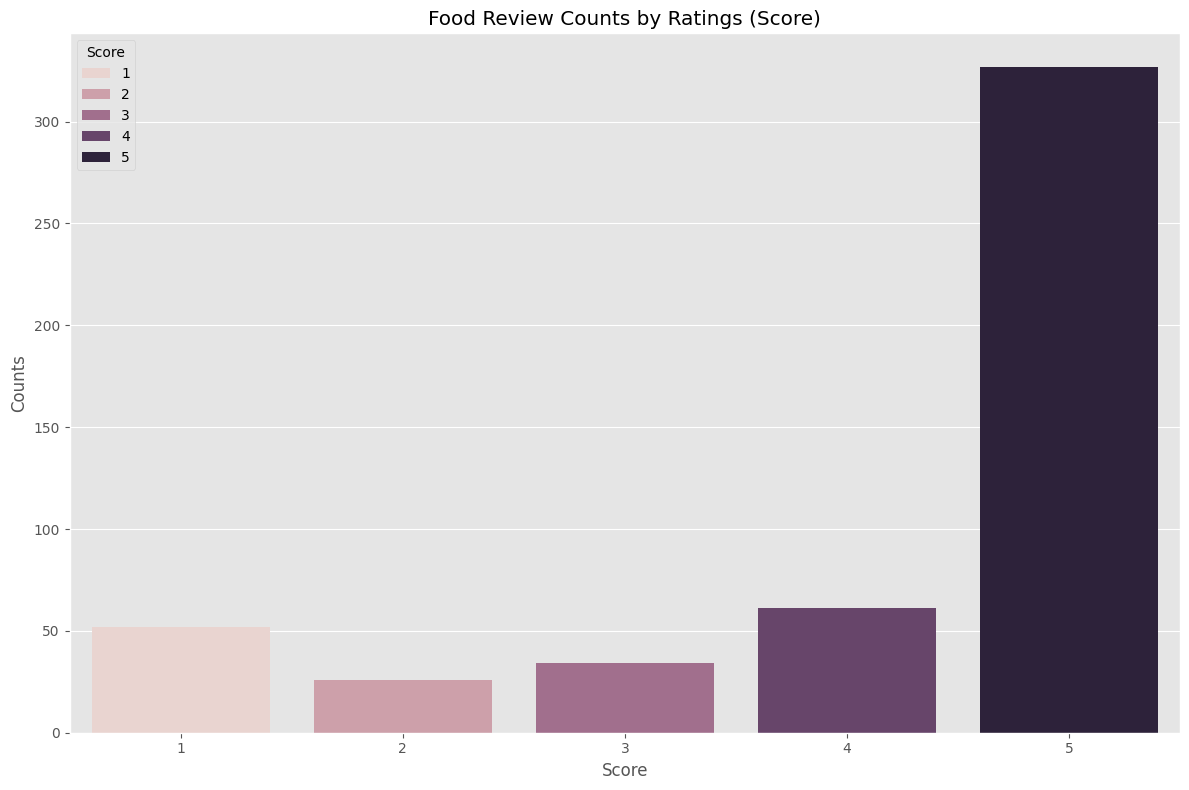

In [8]:
plt.figure(figsize=(12, 8))

sns.countplot(data=df, x='Score', hue='Score')

plt.ylabel('Counts')
plt.title('Food Review Counts by Ratings (Score)')

plt.tight_layout()
plt.show()

After some quick EDA, we can see that our data is **heavily skewed towards 5-star rated reviews.** Let's start doing sentiment analysis using the **Natural Language ToolKit (NLTK)** library.

# NLTK Text Processing

We can follow the text preprocessing workflow here starting **from Tokenization to Lemmatization**.

![Text Preprocessing Procedure](https://images.datacamp.com/image/upload/v1679592730/text_preprocessing_steps_in_sequence_1bcfc50bd0.png)

**Image Source:** [Oreilly](https://www.oreilly.com/api/v2/epubs/9781492074076/files/assets/btap_0401.png)

Text preprocessing helps to clean and normalize text data to make it easier for analysis. Here are the steps we should do:

1. **Tokenization:** Taking a sentence or paragraph and breaking it down into individual pieces (tokens), which are words or punctuation marks. Computers generally do not understand text as a whole, and doing tokenization makes them able to deal with one word at a time, making it more manageable for them.
2. **POS Tagging:** Giving each word in a sentence a name tag based on its job
3. **Stop Word Removal:** This means eliminating common and irrelevant words that do not convey much sentiment (e.g. and, the, of, it).
4. **Lemmatization:** Chopping off endings of words but taking into account the context and meaning in the text.

In [16]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [25]:
def preprocess_text(text):
    """Perform NLTK Text Preprocessing
    1. Tokenization - Break down text into individual pieces
    2. POS Tagging -  Giving each word in a sentence a name tag based on its job
    3. Stop Word Removal - Eliminate irrelevant words that don't convey sentiment
    4. Lemmatization - Revert words to their root form but taking into account the context and meaning
    """
    # Tokenize the text data
    tokens = word_tokenize(text.lower())

    # Tag the tokens
    tagged = pos_tag(tokens)
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join tokens back into a string 
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

We then apply the `preprocess_text()` function to the target column, which is `'Text'`.

In [20]:
df['Text'] = df['Text'].apply(preprocess_text)

In [26]:
df['Text'].values[5]

"far best saltine cracker 've eaten . light airy right amount salt . tasty ! ! !"

Checking on the 5th record in the `'Text'` column, we see that the majority of the words and punctuation marks left here convey a sentiment. This customer review is looking to be a highly positive sentiment.

# VADER Model

Using the `SentimentIntensityAnalyzer` module of `nltk`, we can output the positive, negative, and neutral scores of text.

In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

# Create `SentimentIntensityAnalyzer` Object and Function Testing

Here we create a a sentiment intensity analyzer object `sia` and test its ability to give sentiment scores based on a few examples.

In [28]:
sia

In [29]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [30]:
sia.polarity_scores('I am very sad.')

{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}

In [31]:
sia.polarity_scores('This is the BEST and WORST day of my life!')

{'neg': 0.268, 'neu': 0.443, 'pos': 0.289, 'compound': 0.1007}

In [33]:
example = df['Text'].values[5]
print(example)

far best saltine cracker 've eaten . light airy right amount salt . tasty ! ! !


In [34]:
print(sia.polarity_scores(example))

{'neg': 0.0, 'neu': 0.684, 'pos': 0.316, 'compound': 0.7249}


Polarity scoring basically means giving sentiment scores of positive, neutral, and negative based on the input text.

# Execute Polarity Scoring On the Whole Dataset

Now that we know how polarity scoring works, let's apply it on the whole fine food reviews dataset.

In [35]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,always brew starbucks coffee home rarely consu...
1,115918,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,tasty fresh - like grandma used make . better ...
2,57803,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,< href= `` http : //www.amazon.com/gp/product/...
3,517603,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,nice strong coffee - smooth bit acidic taste e...
4,35950,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,vita coco acai & pomegranate best tasting flav...
...,...,...,...,...,...,...,...,...,...,...
495,431544,B000FDN78Y,A248FKDACBQHOU,"Tom Virnig ""Tom V""",2,2,4,1246838400,spiced sardines,looking year . item came quick taste good reme...
496,221306,B0009PJRMS,A3674WKSOFOSO5,"Alison Mccarthy ""Alison""",5,5,5,1213920000,Olivella!!!,adore soap ! 'm fan strong scent tend fairly d...
497,184814,B002EDISKA,A2RL1RS6PWUHWI,Jennifer Ackerman,0,0,5,1337385600,Best jelly beans out there,"best jelly bean . said , ca n't stand couple f..."
498,379484,B007RLRCLK,A2NVPRHU3VF05G,"Vanessa Cobian ""Butterfly32""",5,5,5,1304553600,Wonderful Tea.,tea helped tremendously getting restful sleep ...


In [36]:
results = {}

for index, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    my_id = row['Id']
    results[my_id] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [37]:
vaders = pd.DataFrame(results).T
vaders = (vaders
              .reset_index()
              .rename(columns={'index': 'Id'})
         )
vaders = vaders.merge(df, how='left')

In [38]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,0.0,0.571,0.429,0.9385,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,always brew starbucks coffee home rarely consu...
1,115918,0.0,0.338,0.662,0.9485,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,tasty fresh - like grandma used make . better ...
2,57803,0.0,0.876,0.124,0.3391,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,< href= `` http : //www.amazon.com/gp/product/...
3,517603,0.0,0.571,0.429,0.9873,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,nice strong coffee - smooth bit acidic taste e...
4,35950,0.0,0.743,0.257,0.7845,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,vita coco acai & pomegranate best tasting flav...


Merging `vaders` with the original DataFrame `df`, lets us have the sentiment scores for each fine food review.

We can assume that if:

- Scores that are equal to 5 imply that the reviews lean more towards being positive
- Scores that are equal to 1 imply that the reviews lean more towards being negative.

# Plot VADER Results

Let's plot the VADER model results to have a quick and easy visualization of the sentiment scores.

In [39]:
vaders['Score'].value_counts(normalize=True)

Score
5    0.654
4    0.122
1    0.104
3    0.068
2    0.052
Name: proportion, dtype: float64

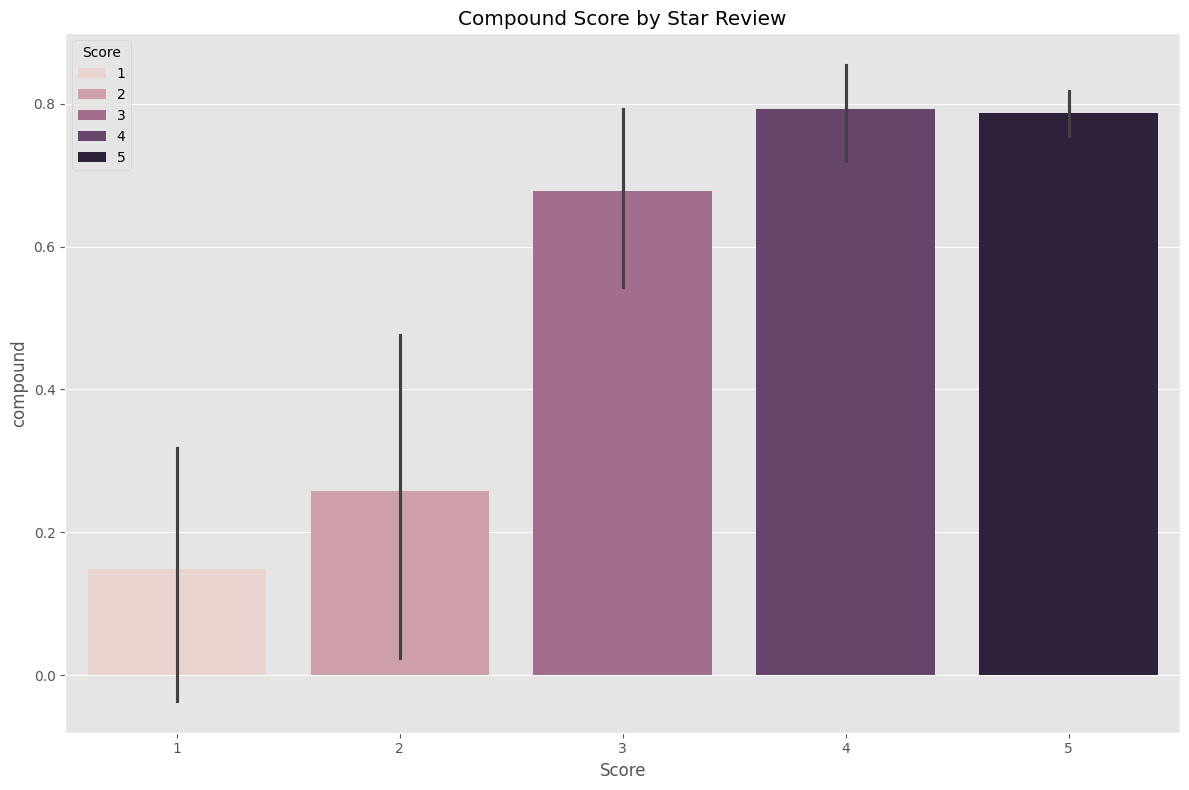

In [40]:
plt.figure(figsize=(12, 8))

ax = sns.barplot(data=vaders, x='Score', y='compound', hue='Score')
ax.set_title('Compound Score by Star Review')

plt.tight_layout()
plt.show()

Our assumptions seem to be aligned with our data.

- The lower the rating, the more negative the review's compound score is
- The higher the rating, the more positive the review's compound score is

Though it's interesting to see that even though the scores are highly skewed towards 5-star ratings, the bar plot seems to be showing that the 4-star rating compound scores are a little bit higher than the 5-star rating compound scores.

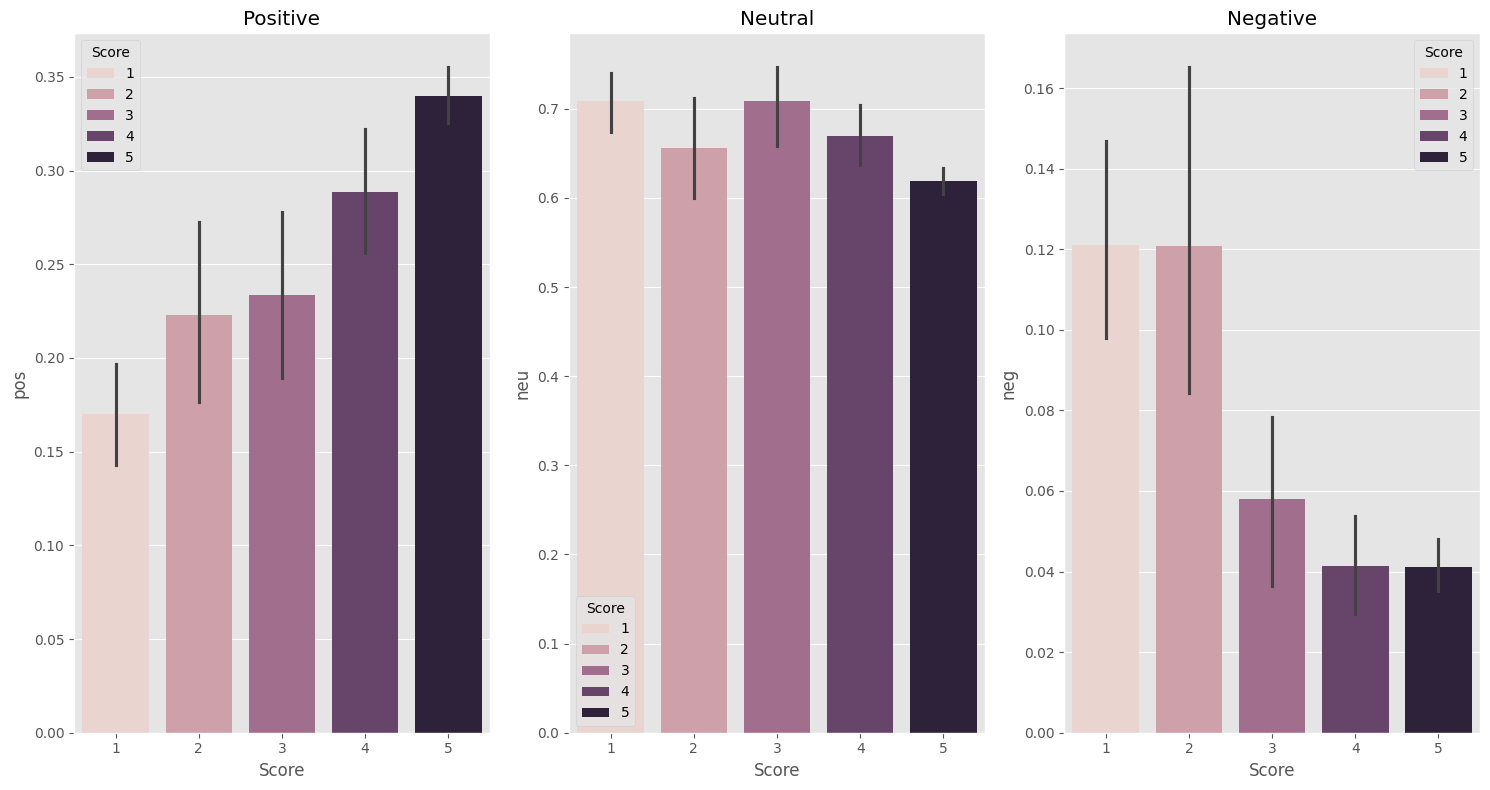

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

sns.barplot(data=vaders, x='Score', y='pos', hue='Score', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', hue='Score', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', hue='Score', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()

plt.show()

Now we show plots for the positive, neutral, and negative score by ratings. It's nice to see that these scores definitely align well with assumptions:

- **Positive Chart:** High ratings have high positive scores as seen in the bar plots of the 4-star and 5-star ratings of the 1st chart
- **Neutral Chart:** Neutral ratings also have fairly neutral scores as seen in the 3-star rating bar plot of the 2nd chart
- **Negative Chart:** Low ratings have high scores in the 1-star and 2-star ratings as seen in the 3rd chart.

# VADER Model Limitation

The VADER model is a great start towards sentiment analysis, but it's biggest limitation is that **it cannot identify relationships between words**. To address this, we must use more complex models that are able to know the context of a given text, let's try to use a **Roberta Pre-trained Model from Hugging Face.**

# Roberta Pre-trained Model

In [42]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

Now we pull a specific pre-trained Roberta model for sentiment analysis. When we run the `AutoTokenizer` and the `AutoModelForSequenceClassification`, and then load the Roberta model in it, it will pull the stored model weights. This is essentially known as **Transfer Learning**, where we utilize a pre-trained model here that was trained on labeled Twitter data, and allows us to eliminate the need of retraining the model.

In [43]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Now we have a new model and tokenizer for our fine food reviews data.

In [44]:
# Recall VADER results
print(example)
sia.polarity_scores(example)

far best saltine cracker 've eaten . light airy right amount salt . tasty ! ! !


{'neg': 0.0, 'neu': 0.684, 'pos': 0.316, 'compound': 0.7249}

# Run Roberta Model

Now we take our new tokenizer and apply it to our example.

In [45]:
tokenizer(example, return_tensors='pt')

{'input_ids': tensor([[    0, 15476,   275,  6740,   833,  7009,   254,   128,   548, 18804,
           479,  1109,   935,   219,   235,  1280,  6740,   479, 22307, 27785,
         27785, 27785,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [46]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.00327625, 0.06085195, 0.9358718 ], dtype=float32)

In [47]:
scores_dict = {
    'roberta_negative' : scores[0],
    'roberta_neutral' : scores[1],
    'roberta_positive' : scores[2]
}
print(scores_dict)

{'roberta_negative': 0.003276255, 'roberta_neutral': 0.060851946, 'roberta_positive': 0.9358718}


In [48]:
def roberta_polarity_scores(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_negative' : scores[0],
        'roberta_neutral' : scores[1],
        'roberta_positive' : scores[2]
    }

    return scores_dict

In [49]:
results = {}
for index, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        my_id = row['Id']
        vader_result = sia.polarity_scores(text)
        
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value
        
        roberta_result = roberta_polarity_scores(text)
        both = {**vader_result_rename, **roberta_result}
        results[my_id] = both
    except RuntimeError:
        print(f'Broke at {my_id}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke at 441093
Broke at 510321


In [50]:
results_df = pd.DataFrame(results).T
results_df = (results_df
                 .reset_index()
                 .rename(columns={'index' : 'Id'}))
results_df = results_df.merge(df, how='left')

In [51]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_negative,roberta_neutral,roberta_positive,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,0.0,0.571,0.429,0.9385,0.009943,0.204246,0.785811,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,always brew starbucks coffee home rarely consu...
1,115918,0.0,0.338,0.662,0.9485,0.006482,0.140544,0.852974,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,tasty fresh - like grandma used make . better ...
2,57803,0.0,0.876,0.124,0.3391,0.326170,0.560306,0.113523,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,< href= `` http : //www.amazon.com/gp/product/...
3,517603,0.0,0.571,0.429,0.9873,0.005954,0.084621,0.909425,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,nice strong coffee - smooth bit acidic taste e...
4,35950,0.0,0.743,0.257,0.7845,0.001888,0.072746,0.925366,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,vita coco acai & pomegranate best tasting flav...


# Compare VADER and Roberta Model Scores

Now let's plot the VADER model's sentiment scores against the new Roberta model scores.

In [52]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_negative', 'roberta_neutral', 'roberta_positive', 'ProductId',
       'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [64]:
results_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_negative,roberta_neutral,roberta_positive,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,246455,0.000,0.571,0.429,0.9385,0.009943,0.204246,0.785811,B002D4DY8G,A11EXFO14WEJM1,Sudarshan Karkada,0,0,4,1259539200,Good coffee - if you are into flavored coffee,always brew starbucks coffee home rarely consu...
1,115918,0.000,0.338,0.662,0.9485,0.006482,0.140544,0.852974,B00348F9I8,A2ITC756URQ2PA,Curley,0,0,5,1327968000,Best there is,tasty fresh - like grandma used make . better ...
2,57803,0.000,0.876,0.124,0.3391,0.326170,0.560306,0.113523,B000EVOSE4,A2B14PJBB4I1MF,Chris,4,7,1,1299628800,So hard! Not edible!,< href= `` http : //www.amazon.com/gp/product/...
3,517603,0.000,0.571,0.429,0.9873,0.005954,0.084621,0.909425,B00954NY46,AAYPNKBSZVUBZ,R.C.,2,2,5,1299974400,Nice strong BOLD coffee,nice strong coffee - smooth bit acidic taste e...
4,35950,0.000,0.743,0.257,0.7845,0.001888,0.072746,0.925366,B0085G4A7U,A2CT0K7QK1O1OI,Ressa,0,0,5,1331942400,My favorite of the Vita Coco beverages is this...,vita coco acai & pomegranate best tasting flav...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,431544,0.000,0.868,0.132,0.4404,0.006143,0.246647,0.747209,B000FDN78Y,A248FKDACBQHOU,"Tom Virnig ""Tom V""",2,2,4,1246838400,spiced sardines,looking year . item came quick taste good reme...
494,221306,0.044,0.505,0.451,0.9697,0.005141,0.051985,0.942874,B0009PJRMS,A3674WKSOFOSO5,"Alison Mccarthy ""Alison""",5,5,5,1213920000,Olivella!!!,adore soap ! 'm fan strong scent tend fairly d...
495,184814,0.050,0.721,0.229,0.8652,0.005108,0.050012,0.944879,B002EDISKA,A2RL1RS6PWUHWI,Jennifer Ackerman,0,0,5,1337385600,Best jelly beans out there,"best jelly bean . said , ca n't stand couple f..."
496,379484,0.000,0.798,0.202,0.4173,0.004258,0.150843,0.844900,B007RLRCLK,A2NVPRHU3VF05G,"Vanessa Cobian ""Butterfly32""",5,5,5,1304553600,Wonderful Tea.,tea helped tremendously getting restful sleep ...


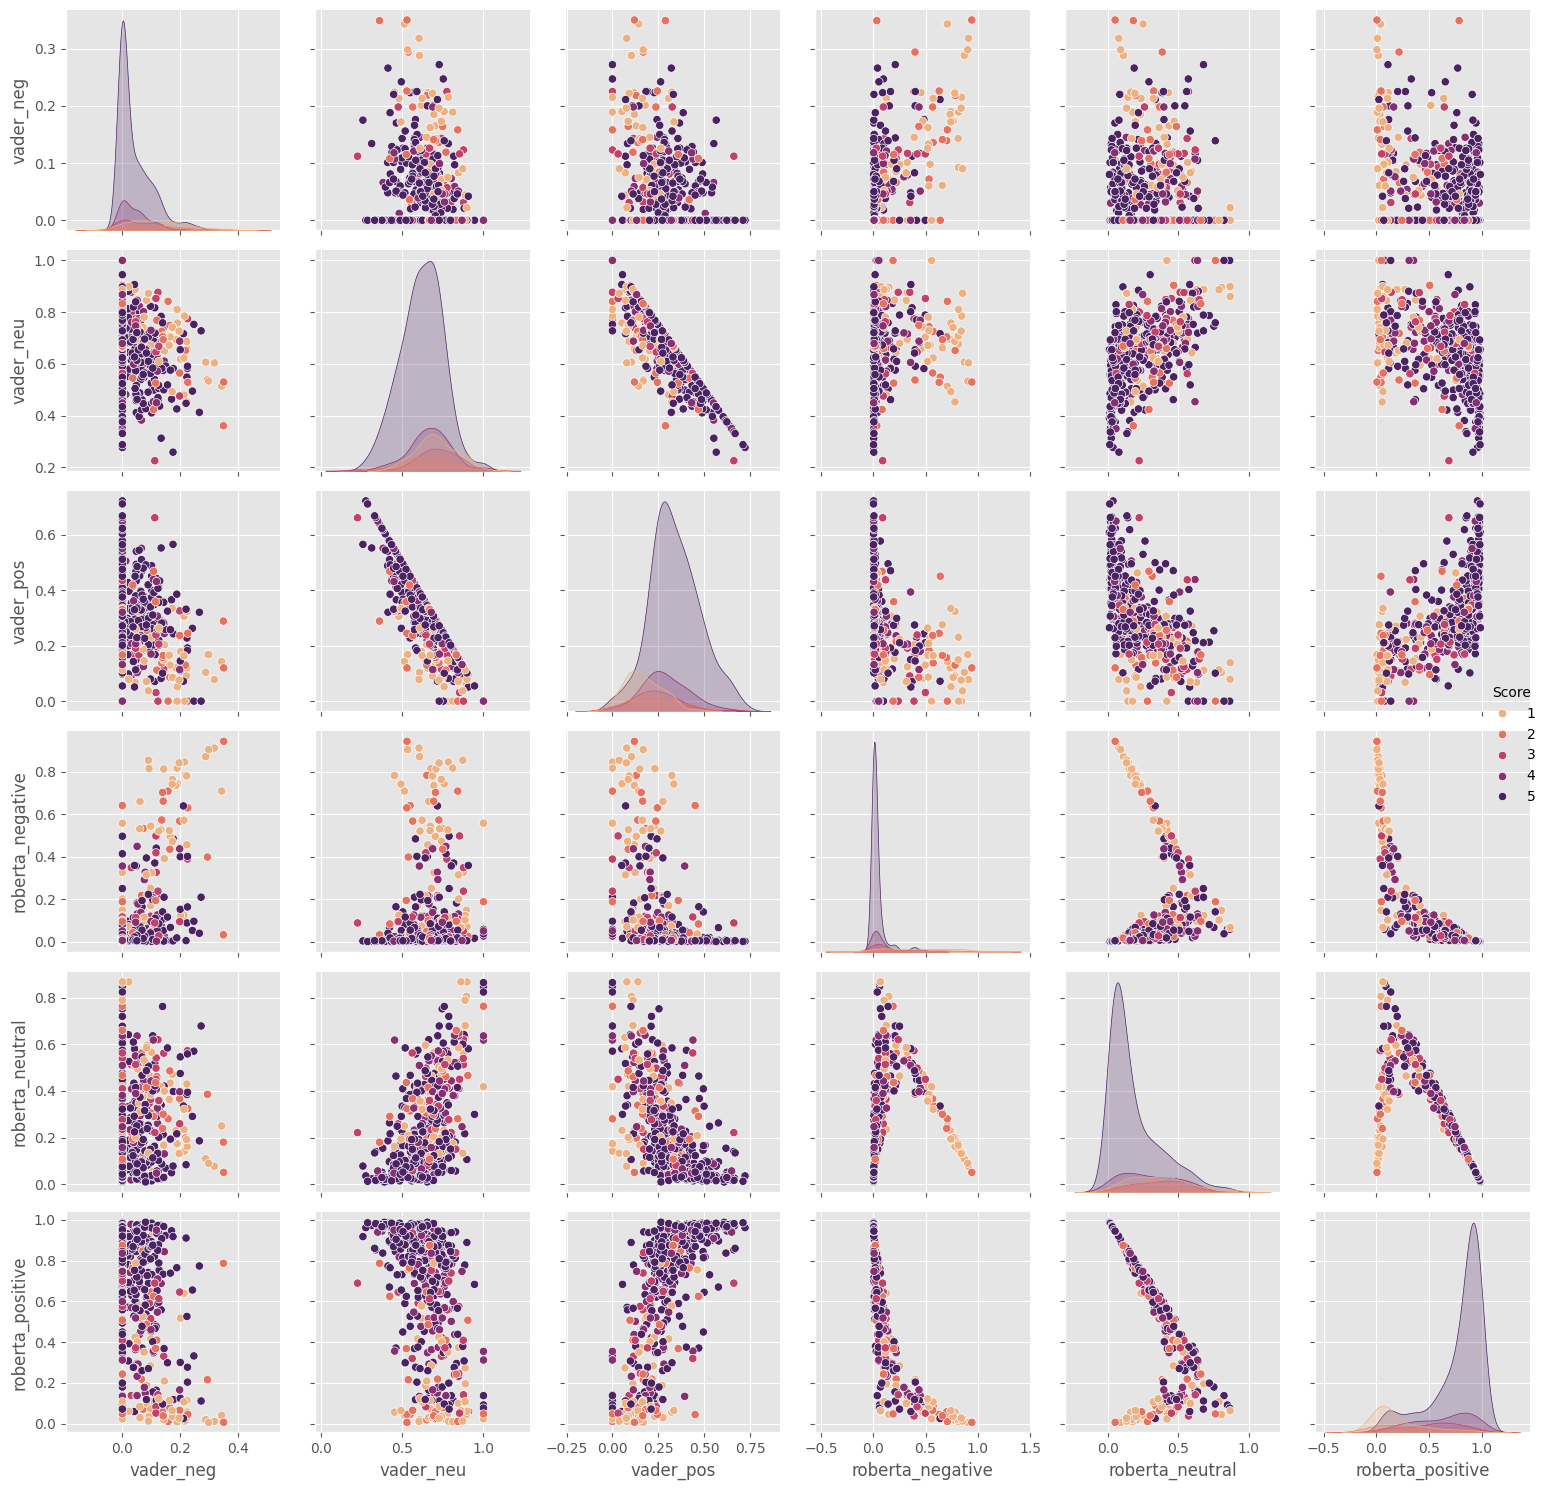

In [53]:
sns.pairplot(data=results_df, 
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_negative', 'roberta_neutral', 'roberta_positive'],
            hue='Score',
            palette='flare')

plt.tight_layout()
plt.show()

- There are some **correlations between the VADER and Roberta model scores**.
- The **VADER model seems to be less confident** in giving its sentiment scores.
- The **Roberta model seems more confident** in its ability to give out sentiment scores.

# Review Examples

- Positive 1-star and Negative 5-star ratings

Let's inspect instances wherein the model score and review score differ the most.

# Positive Sentiment 1-Star Review

We look at some examples where the VADER and Roberta Model gave high positive sentiment scores despite having a 1-star review on the dataset.

In [54]:
results_df.query('Score == 1') \
    .sort_values('roberta_positive', ascending=False)['Text'].values[0]

"product came time good shape . ca n't complain amazon service . product good . almost inedible . normally love salmon roe . use found procuct use small amount decorate canape deviled egg . order !"

The example above shows an instance where the roberta model gave a high positive score despite having a 1-star review based  on our data. It seems like the model had given heavy weights on words and phrases such as "product came time good shape", and "product good". But we can clearly see words such as "almost inedible" "use small amount decor" "can't complain amazon service" which typically denote negative sentiments.

In [55]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'product listed special gluten free food promotion . glad read ingredient first ! although cooky sound wonderful , buyer beware ! buying someone allergy intolerance would wise choice .'

Now for the other example above, we look at the VADER model this time. The VADER model scored a high positive sentiment, but there are obvious phrases such as "buyer beware!", "glad read ingredient first!" that typically denote negative sentiments.

# Negative sentiment 5-star review

This time, we look at instances where both models have given high negative sentiment scores despite having 5-star reviews on the dataset.

In [57]:
results_df.query('Score == 5') \
    .sort_values(by='roberta_negative', ascending=False)['Text'].values[0]

'tuscany recently , despite sincerest effort unable sight tuscan whole . given rarity creature , find hard believe anyone one managed domesticate , let alone convince give milk .'

Again from the Roberta model, it's a little bit hard to determine what the context of this review is since we did stop word removal, but given some of the phrases here, this does sound like more of a negative sentiment rather than a positive sentiment.

In [58]:
results_df.query('Score == 5') \
    .sort_values(by='vader_neg', ascending=False)['Text'].values[0]

"scream u 18 month . give one serving vegetable sometimes 's hard get eat otherwise ."

Now for the VADER model, we can see why this model gave a high negative sentiment score despite having a 5-star review on the dataset. "Scream u 18 month" seems like a pretty scary sentiment, and I would assume that the model has given heavy weight for this phrase.

# Hugging Face Transformers Pipeline

Using the **Hugging Face Transformers Pipeline** allows you to easily run sentiment analysis predictions with just importing the `pipeline` module from `transformers` and using a few lines of code.

In [59]:
from transformers import pipeline

In [60]:
sentiment_pipeline = pipeline(task='sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


This pipeline automatically downloads a default model and its embeddings when you input the task it needs to do. In this case, since we are doing sentiment analysis, it downloads the default model for sentiment analysis. Let's test out how it does with a few sample texts.

In [61]:
sentiment_pipeline('I love sentiment analysis')

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [62]:
sentiment_pipeline('Booooooooo')

[{'label': 'NEGATIVE', 'score': 0.504004180431366}]

In [65]:
print(example)

far best saltine cracker 've eaten . light airy right amount salt . tasty ! ! !


In [66]:
sentiment_pipeline(example)

[{'label': 'POSITIVE', 'score': 0.9997729659080505}]

In [68]:
pipeline_results = {}

for index, row in tqdm(df.iterrows(), total=len(df)):
	try:
		text = row['Text']
		my_id = row['Id']
		pipeline_results[my_id] = sentiment_pipeline(text)
	except RuntimeError:
		print(f'Broke at {my_id}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke at 441093
Broke at 510321


In [71]:
pipeline_results

{246455: [{'label': 'POSITIVE', 'score': 0.8068896532058716}],
 115918: [{'label': 'POSITIVE', 'score': 0.9945089221000671}],
 57803: [{'label': 'NEGATIVE', 'score': 0.994251012802124}],
 517603: [{'label': 'POSITIVE', 'score': 0.9945251941680908}],
 35950: [{'label': 'POSITIVE', 'score': 0.997969925403595}],
 84014: [{'label': 'POSITIVE', 'score': 0.9997729659080505}],
 356501: [{'label': 'POSITIVE', 'score': 0.7936478853225708}],
 335919: [{'label': 'NEGATIVE', 'score': 0.994716465473175}],
 75923: [{'label': 'NEGATIVE', 'score': 0.9965673685073853}],
 379294: [{'label': 'POSITIVE', 'score': 0.9964641332626343}],
 189010: [{'label': 'NEGATIVE', 'score': 0.9743959903717041}],
 28506: [{'label': 'POSITIVE', 'score': 0.925390362739563}],
 395078: [{'label': 'POSITIVE', 'score': 0.9407520294189453}],
 360558: [{'label': 'NEGATIVE', 'score': 0.9991812109947205}],
 524701: [{'label': 'POSITIVE', 'score': 0.9971140623092651}],
 184851: [{'label': 'POSITIVE', 'score': 0.997010350227356}],
 5

# References

- Ali, M. (2023, March 23). _NLTK Sentiment Analysis Tutorial for Beginners_. Retrieved December 6, 2023, from https://www.datacamp.com/tutorial/text-analytics-beginners-nltk

- Rob Mulla. (2022). _Python Sentiment Analysis Project with NLTK and 🤗 Transformers. Classify Amazon Reviews!!_ [Video]. YouTube. https://www.youtube.com/watch?v=QpzMWQvxXWk

- Robikscube. (2022). _Sentiment Analysis Python 🤗 [Youtube Tutorial]_. Kaggle. https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook

- Stanford Network Analysis Project. (2016). _Amazon Fine Food Reviews_. Kaggle. https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews